In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (ConfusionMatrixDisplay,
    classification_report, RocCurveDisplay)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers.experimental import Adagrad
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import elu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.random import set_seed

2023-01-19 17:23:08.757315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Modeling

In [21]:
data = pd.read_csv('data/aqs_by_county_clean.csv')

In [22]:
data

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
0,alabama,jefferson,2014,0.578752,28.600838,0.048302,24.918033,11.698347,687.0,1940.866,34.068,7376.0,3216.859,38.508,0.093,1
1,alabama,jefferson,2015,0.526681,22.163818,0.047164,23.883333,11.772881,681.0,1903.761,33.633,7032.0,3210.182,38.434,0.097,1
2,alabama,jefferson,2016,0.444555,28.544643,0.051325,24.256809,10.781667,709.0,1947.176,34.059,7061.0,3188.066,38.456,0.100,1
3,alabama,jefferson,2017,0.367024,20.712610,0.045971,22.300057,10.325455,662.0,1929.279,34.045,6767.0,3202.834,38.456,0.098,1
4,alabama,jefferson,2018,0.344179,23.718644,0.049131,22.985533,10.329508,570.0,1959.763,34.040,6560.0,3222.885,38.468,0.087,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,wisconsin,milwaukee,2016,0.280834,26.110028,0.050033,16.620690,8.269167,795.0,1962.247,34.033,10018.0,3259.449,38.561,0.079,0
1008,wisconsin,milwaukee,2017,0.208109,24.988764,0.048237,14.304348,8.648276,816.0,1939.854,33.819,9529.0,3226.689,38.481,0.086,1
1009,wisconsin,milwaukee,2018,0.286275,25.089326,0.048181,15.573770,8.976557,829.0,2000.789,34.219,9700.0,3237.059,38.500,0.085,1
1010,wisconsin,milwaukee,2019,0.302550,24.405801,0.045103,17.589876,8.768545,809.0,1953.597,34.042,9087.0,3217.324,38.427,0.089,1


#### Define X, y and train/test split

In [23]:
data.columns

Index(['state', 'county', 'year', 'Carbon monoxide', 'Nitrogen dioxide (NO2)',
       'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions',
       'births_low', 'avg_weight_low', 'avg_ges_age_low', 'births_all',
       'avg_weight_all', 'avg_ges_age_all', 'pct_low', 'high_rate'],
      dtype='object')

In [24]:
X = data[['Carbon monoxide', 'Nitrogen dioxide (NO2)','Ozone','PM10 Total 0-10um STP','PM2.5 - Local Conditions']]
y = data['high_rate']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=.2,
                                                    stratify=y,
                                                    random_state=5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((809, 5), (203, 5), (809,), (203,))

In [26]:
pd.DataFrame(y_train).value_counts(normalize=True), pd.DataFrame(y_test).value_counts(normalize=True)

(high_rate
 0            0.878863
 1            0.121137
 dtype: float64,
 high_rate
 0            0.876847
 1            0.123153
 dtype: float64)

In [27]:
train_baseline = pd.DataFrame(y_train).value_counts(normalize=True).iloc[0]
test_baseline = pd.DataFrame(y_test).value_counts(normalize=True).iloc[0]
train_baseline, test_baseline

(0.8788627935723115, 0.8768472906403941)

#### Scale the data

In [28]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

#### Build the model

In [29]:
# saved as model_9261(!!!)
# set_seed(42)

# custom_elu = lambda x: elu(x, alpha=1e-2)

# best_model_saver = ModelCheckpoint(filepath='data/new_model',
#                                    monitor='val_accuracy',
#                                    save_best_only=True,
#                                    initial_value_threshold=.910,
#                                    save_weights_only=True,
#                                    mode='max',
#                                    verbose=1)

# model = Sequential()
# model.add(Dense(600, input_dim=X_train_ss.shape[1], activation=custom_elu))
# model.add(Dropout(.2))
# model.add(Dense(300, activation=custom_elu))
# model.add(Dropout(.2))
# model.add(Dense(200, activation=custom_elu))
# model.add(Dropout(.2))
# model.add(Dense(100, activation=custom_elu))
# model.add(Dropout(.2))
# model.add(Dense(50, activation=custom_elu))
# model.add(Dropout(.2))
# model.add(Dense(100, activation=custom_elu))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer=Adagrad(learning_rate=.25), 
#               loss='bce', 
#               metrics=['accuracy'])

# history = model.fit(X_train_ss, y_train,
#                     batch_size=8, epochs=500,
#                     callbacks=[best_model_saver],
#                     validation_data=(X_test_ss, y_test))

#----------------------------------------------------------------------------

# saved as models_9163
# set_seed(42)

# custom_elu = lambda x: elu(x, alpha=1e-2)

# best_model_saver = ModelCheckpoint(filepath='data/models/new_model',
#                                    monitor='val_accuracy',
#                                    save_best_only=True,
#                                    initial_value_threshold=.9,
#                                    save_weights_only=True,
#                                    mode='max')

# model = Sequential()
# model.add(Dense(600, input_dim=X_train_ss.shape[1], activation=custom_elu))
# model.add(Dense(300, activation=custom_elu))
# model.add(Dense(200, activation=custom_elu))
# model.add(Dense(100, activation=custom_elu))
# model.add(Dense(50, activation=custom_elu))
# model.add(Dense(100, activation=custom_elu))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer=Adagrad(learning_rate=.5), 
#               loss='bce', 
#               metrics=['accuracy'])

# history = model.fit(X_train_ss, y_train,
#                     batch_size=8, epochs=500,
#                     callbacks=[best_model_saver],
#                     validation_data=(X_test_ss, y_test))

#----------------------------------------------------------------------------

# This attempt got accuracy of .9015
# custom_elu = lambda x: elu(x, alpha=1e-2)

# model = Sequential()
# model.add(Dense(600, input_dim=X_train_ss.shape[1], activation=custom_elu))
# model.add(Dense(300, activation=custom_elu))
# model.add(Dense(200, activation=custom_elu))
# model.add(Dense(100, activation=custom_elu))
# model.add(Dense(50, activation=custom_elu))
# model.add(Dense(100, activation=custom_elu))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer=Adagrad(learning_rate=.5), 
#               loss='bce', 
#               metrics=['accuracy'])

# history = model.fit(X_train_ss, y_train,
#                     batch_size=8, epochs=100,
#                     # callbacks=EarlyStopping(patience=5),
#                     validation_data=(X_test_ss, y_test))

#----------------------------------------------------------------------------

# Tried replacing elu with relu just to see difference, slightly worse performance (.8818 accuracy)
# custom_elu = lambda x: elu(x, alpha=1e-2)

# model = Sequential()
# model.add(Dense(600, input_dim=X_train_ss.shape[1], activation='relu'))
# model.add(Dense(300, activation='relu'))
# model.add(Dense(200, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer=Adagrad(learning_rate=.5), 
#               loss='bce', 
#               metrics=['accuracy'])

# history = model.fit(X_train_ss, y_train,
#                     batch_size=8, epochs=100,
#                     # callbacks=EarlyStopping(patience=5),
#                     validation_data=(X_test_ss, y_test))

#### Must run this cell in order to be able to load model results

In [30]:
set_seed(42)

custom_elu = lambda x: elu(x, alpha=1e-2)

best_model_saver = ModelCheckpoint(filepath='data/new_model',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   initial_value_threshold=.920,
                                   save_weights_only=True,
                                   mode='max')

model = Sequential()
model.add(Dense(600, input_dim=X_train_ss.shape[1], activation=custom_elu))
model.add(Dropout(.2))
model.add(Dense(300, activation=custom_elu))
model.add(Dropout(.2))
model.add(Dense(200, activation=custom_elu))
model.add(Dropout(.2))
model.add(Dense(100, activation=custom_elu))
model.add(Dropout(.2))
model.add(Dense(50, activation=custom_elu))
model.add(Dropout(.2))
model.add(Dense(100, activation=custom_elu))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adagrad(learning_rate=.25), 
              loss='bce', 
              metrics=['accuracy'])

#### Skip this cell unless you wish to train new model

In [32]:
history = model.fit(X_train_ss, y_train,
                    batch_size=8, epochs=500,
                    callbacks=[best_model_saver],
                    validation_data=(X_test_ss, y_test),
                    verbose=0)

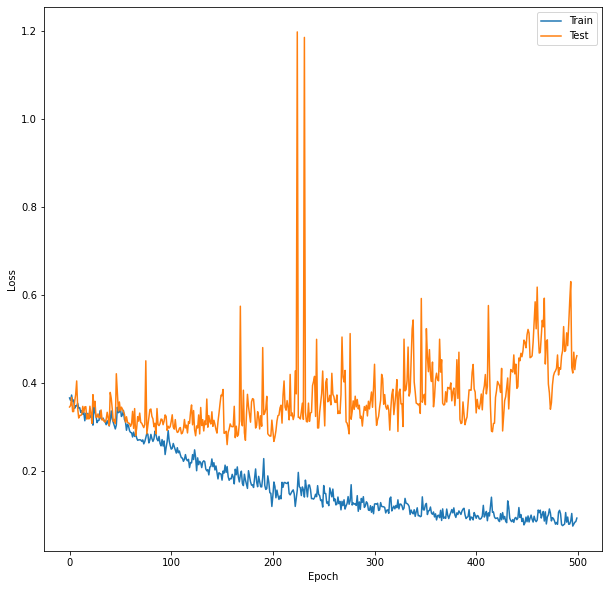

In [33]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,2])
plt.legend();

## Loading in best model

In [34]:
model.load_weights('data/new_model')

In [39]:
model.load_weights('data/models/model_9261')

#### Generate predictions for performance analysis

In [40]:
y_pred = model.predict(X_test_ss)
y_pred = pd.Series(y_pred.reshape(-1))
y_pred = y_pred.map(lambda x: 1 if x>.5 else 0)

7/7 [==============================] - 0s 6ms/step


In [41]:
pd.DataFrame(classification_report(y_test, y_pred,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.935829,0.812500,0.926108,0.874164,0.920641
recall,0.983146,0.520000,0.926108,0.751573,0.926108
f1-score,0.958904,0.634146,0.926108,0.796525,0.918909
support,178.000000,25.000000,0.926108,203.000000,203.000000


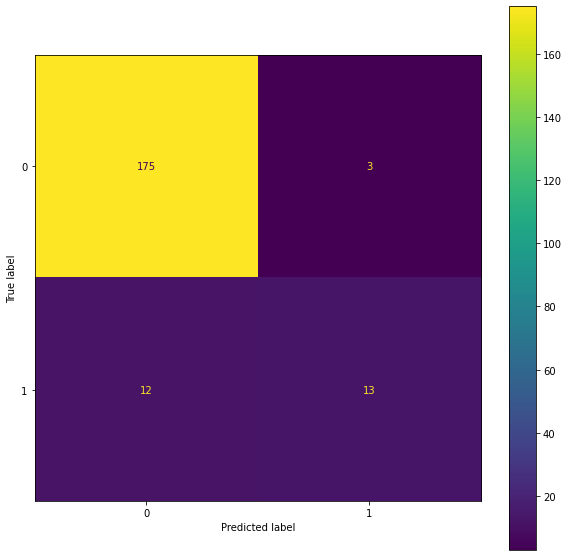

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax);

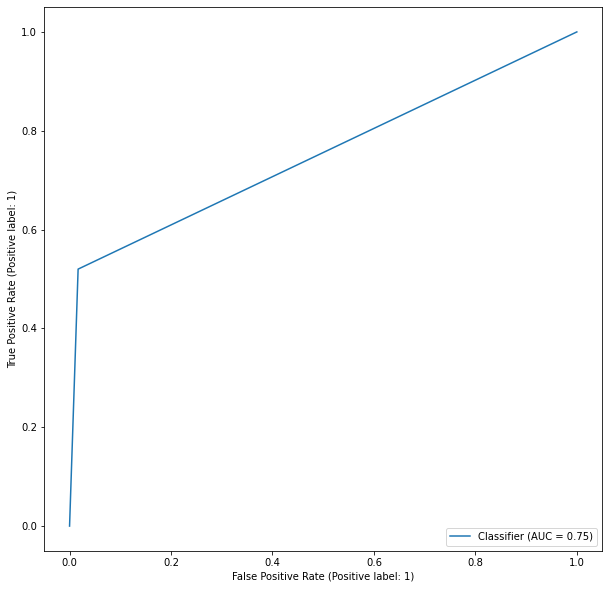

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax);

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 600)               3600      
                                                                 
 dropout_15 (Dropout)        (None, 600)               0         
                                                                 
 dense_22 (Dense)            (None, 300)               180300    
                                                                 
 dropout_16 (Dropout)        (None, 300)               0         
                                                                 
 dense_23 (Dense)            (None, 200)               60200     
                                                                 
 dropout_17 (Dropout)        (None, 200)               0         
                                                                 
 dense_24 (Dense)            (None, 100)              

In [3]:
lbw = pd.read_csv('data/Natality_by_year_2007-2021.txt', sep="\t")
lbw.columns = [col.lower().replace(' ', '_') for col in lbw.columns]

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

## EDA with AQS data

In [117]:
data_path = Path('data/aqs_county_files/')

# create a list of all the AQI csv files
aqs_dfs = [
    pd.read_csv(file) for file in data_path.glob('AQS_county*') if file.is_file()
]

# for file in data_path.glob('AQS_county*'):
#     if file.is_file():
#         print(file)
#         pd.read_csv(file)

# concatenate the dataframes
aqs = pd.concat(aqs_dfs)

In [118]:
# aqs = pd.read_csv('data/aqs_by_county_clean.csv')

In [119]:
aqs.shape

(333008, 57)

In [120]:
aqs = aqs[aqs['validity_indicator']=='Y']

In [121]:
aqs.shape

(273633, 57)

In [122]:
drop = ['state_code',
 'county_code',
 'site_number',
 'parameter_code',
 'poc',
 'latitude',
 'longitude',
 'city', 'cbsa_code', 'cbsa', 'date_of_last_change',
 'first_max_value',
  'first_max_datetime',
  'second_max_value',
  'second_max_datetime',
  'third_max_value',
  'third_max_datetime',
  'fourth_max_value',
  'fourth_max_datetime',
  'first_max_nonoverlap_value',
  'first_max_n_o_datetime',
  'second_max_nonoverlap_value',
  'second_max_n_o_datetime',
  'ninety_ninth_percentile',
  'ninety_eighth_percentile',
  'ninety_fifth_percentile',
  'ninetieth_percentile',
  'seventy_fifth_percentile',
  'fiftieth_percentile',
  'tenth_percentile',
  'local_site_name',
  'site_address',
 'datum',
 'units_of_measure',
 'sample_duration',
 'secondary_exceedance_count',
 'pollutant_standard',
 'metric_used',
 'method',
 'event_type',
 'observation_count',
 'observation_percent',
 'required_day_count',
 'exceptional_data_count',
 'null_observation_count']

In [123]:
aqs.drop(columns=drop, inplace=True)

In [124]:
aqs.columns

Index(['parameter', 'sample_duration_code', 'year', 'validity_indicator',
       'valid_day_count', 'primary_exceedance_count',
       'certification_indicator', 'arithmetic_mean', 'standard_deviation',
       'state', 'county', 'Unnamed: 0'],
      dtype='object')

In [125]:
aqs['county'].unique().shape

(882,)

In [126]:
aqs['parameter'].value_counts()

PM2.5 - Local Conditions    114892
Ozone                        85983
Sulfur dioxide               28093
PM10 Total 0-10um STP        20520
Nitrogen dioxide (NO2)       11472
Carbon monoxide              10581
Lead (TSP) LC                 1959
Lead PM10 LC FRM/FEM           133
Name: parameter, dtype: int64

#### Far too few entries for the lead data, so will drop those columns after the following pivot

In [127]:
aqs = pd.pivot_table(aqs, values="arithmetic_mean", 
                       index=["state", "county", "year"], 
                       columns=["parameter"],
                       aggfunc='max').reset_index()

In [128]:
aqs

parameter,state,county,year,Carbon monoxide,Lead (TSP) LC,Lead PM10 LC FRM/FEM,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,Sulfur dioxide
0,Alabama,Baldwin,2006,NaN,NaN,NaN,NaN,0.056816,NaN,NaN,NaN
1,Alabama,Baldwin,2007,NaN,NaN,NaN,NaN,0.053065,NaN,10.441818,NaN
2,Alabama,Baldwin,2008,NaN,NaN,NaN,NaN,0.044948,NaN,NaN,NaN
3,Alabama,Baldwin,2009,NaN,NaN,NaN,NaN,0.042444,NaN,NaN,NaN
4,Alabama,Baldwin,2010,NaN,NaN,NaN,NaN,0.050758,NaN,10.238525,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15425,Wyoming,Weston,2017,NaN,NaN,NaN,NaN,0.049192,NaN,NaN,0.777374
15426,Wyoming,Weston,2018,NaN,NaN,NaN,NaN,0.050424,NaN,NaN,0.936813
15427,Wyoming,Weston,2019,NaN,NaN,NaN,NaN,0.048662,NaN,NaN,1.195068
15428,Wyoming,Weston,2020,NaN,NaN,NaN,NaN,0.048840,NaN,NaN,0.542659


In [129]:
aqs.columns

Index(['state', 'county', 'year', 'Carbon monoxide', 'Lead (TSP) LC',
       'Lead PM10 LC FRM/FEM', 'Nitrogen dioxide (NO2)', 'Ozone',
       'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions', 'Sulfur dioxide'],
      dtype='object', name='parameter')

In [130]:
aqs.drop(columns=['Lead (TSP) LC', 'Lead PM10 LC FRM/FEM', 'Sulfur dioxide'], inplace=True)

In [131]:
aqs.isnull().sum()

parameter
state                           0
county                          0
year                            0
Carbon monoxide             12409
Nitrogen dioxide (NO2)      11801
Ozone                        3234
PM10 Total 0-10um STP       10220
PM2.5 - Local Conditions     6917
dtype: int64

In [134]:
params = ['Carbon monoxide', 'Nitrogen dioxide (NO2)',
       'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions']

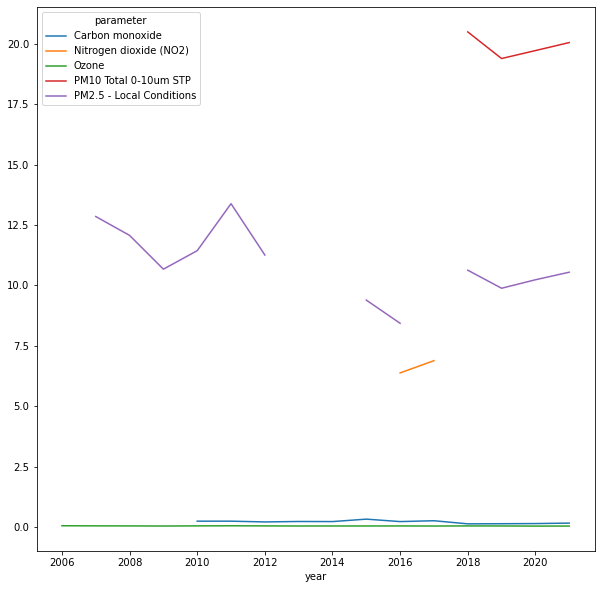

In [135]:
aqs[aqs['county']=='Hinds'].plot(x='year', y=params,
                                 figsize=(10,10));

In [172]:
def plot_county_pollutants(data, county_state):
    params = ['Carbon monoxide', 'Nitrogen dioxide (NO2)',
               'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions']

    for county, state in county_state:
        aqs[(aqs['county']==county)&(aqs['state']==state)].plot\
                (x='year', y=params,
                 figsize=(10,10),
                 title=f'{county} County, {state}');
        plt.show()
    return None

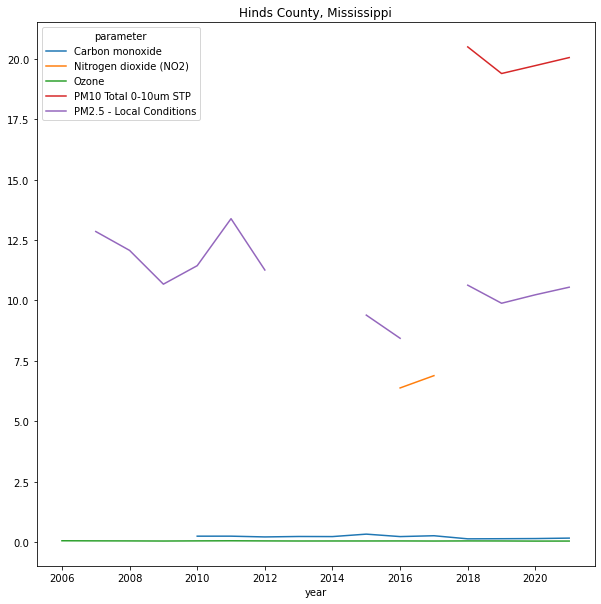

In [176]:
plot_county_pollutants(aqs, [['Hinds', 'Mississippi']])

In [174]:
aqs[['county','state']].sample(10).values

array([['Chittenden', 'Vermont'],
       ['Dunn', 'North Dakota'],
       ['Alachua', 'Florida'],
       ['Ventura', 'California'],
       ['Winchester City', 'Virginia'],
       ['Wayne', 'New York'],
       ['Clark', 'Arkansas'],
       ['Douglas', 'Nevada'],
       ['Lyon', 'Nevada'],
       ['Yuma', 'Arizona']], dtype=object)

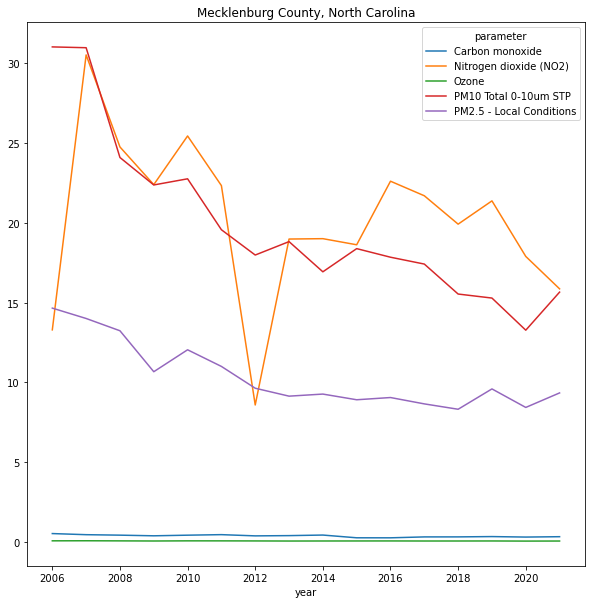

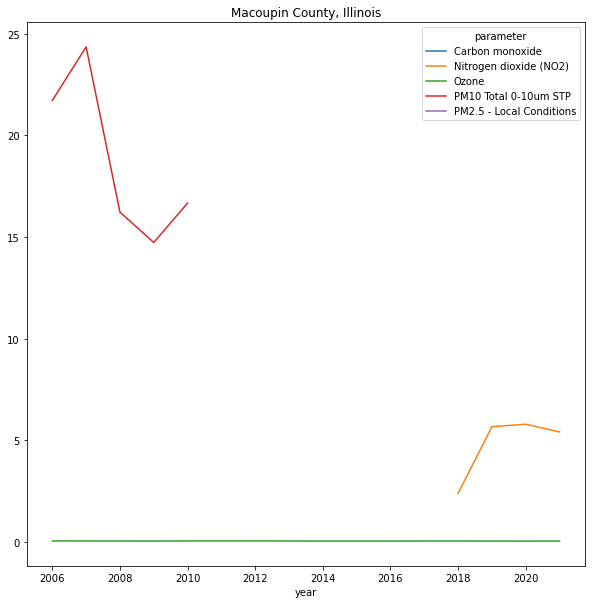

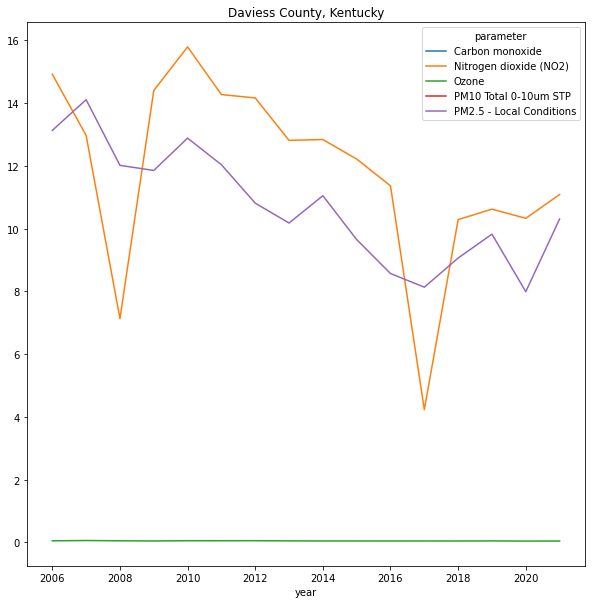

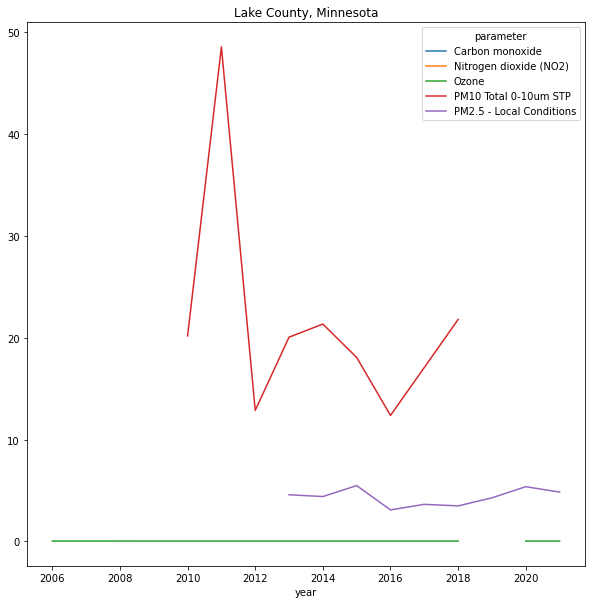

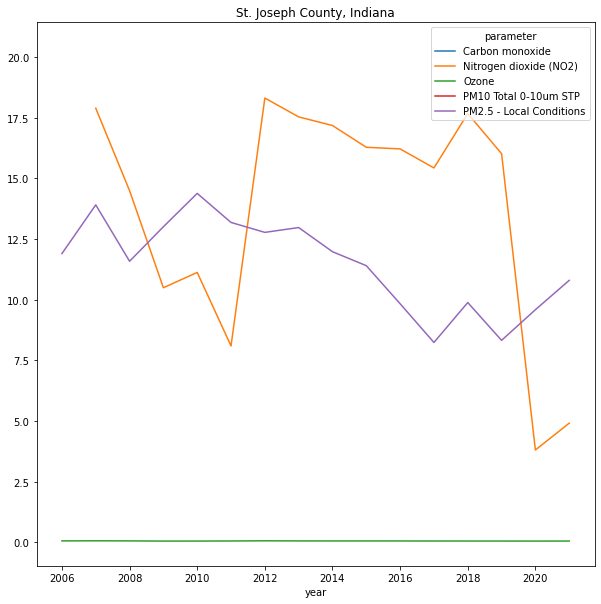

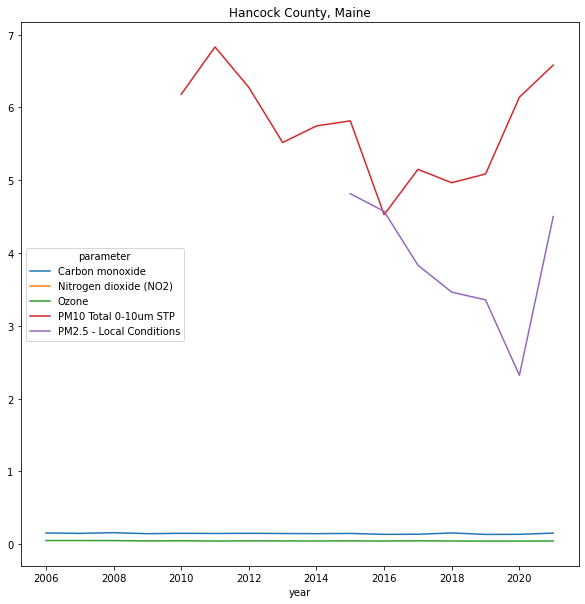

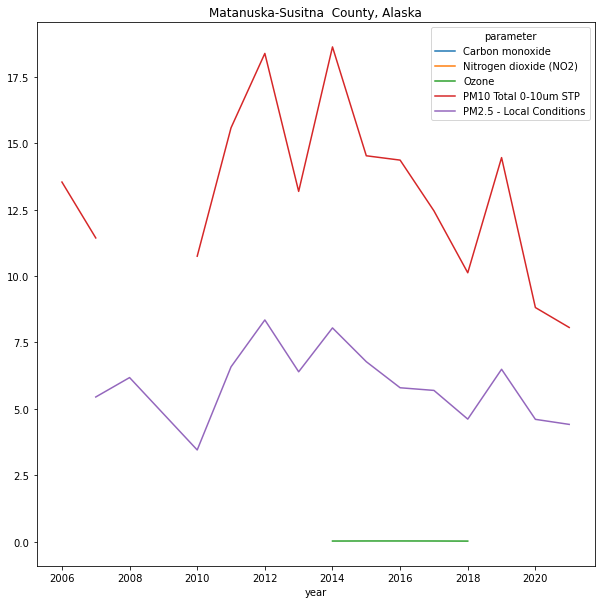

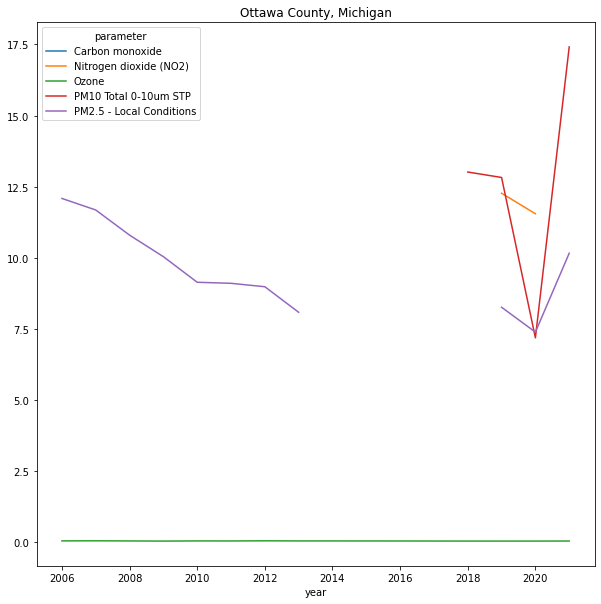

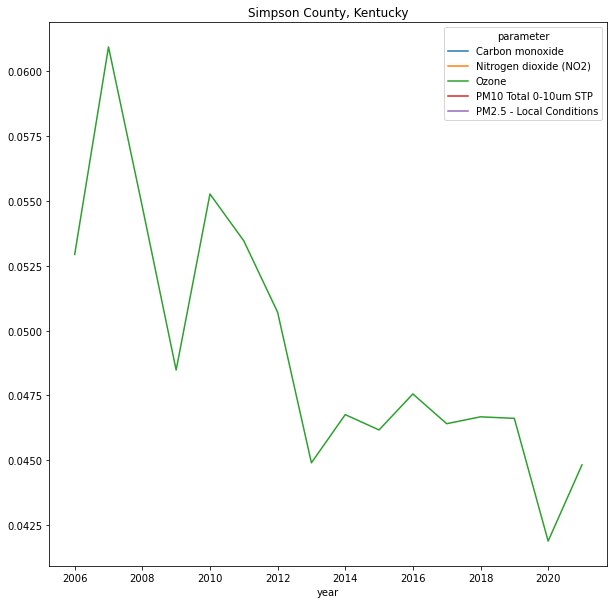

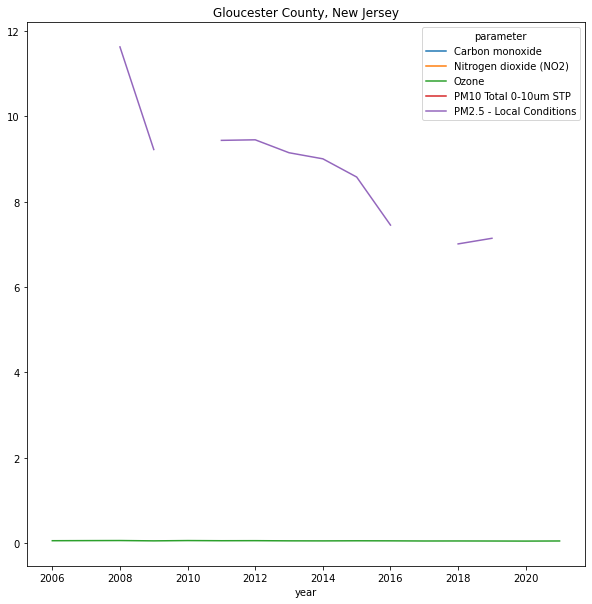

In [175]:
plot_county_pollutants(aqs, aqs[['county','state']].sample(10).values)

In [163]:
aqs[aqs['county']=='Montgomery']

parameter,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions
160,Alabama,Montgomery,2006,NaN,NaN,0.053582,24.516667,15.262069
161,Alabama,Montgomery,2007,NaN,NaN,0.055434,24.625000,NaN
162,Alabama,Montgomery,2008,NaN,NaN,0.050290,25.796610,11.850932
163,Alabama,Montgomery,2009,NaN,NaN,0.044482,17.633333,10.478529
164,Alabama,Montgomery,2010,NaN,NaN,0.052381,24.762712,12.392039
...,...,...,...,...,...,...,...,...
13217,Texas,Montgomery,2021,NaN,7.537255,0.045768,NaN,NaN
14018,Virginia,Montgomery,2018,NaN,NaN,NaN,NaN,NaN
14019,Virginia,Montgomery,2019,NaN,NaN,NaN,NaN,NaN
14020,Virginia,Montgomery,2020,NaN,NaN,NaN,NaN,NaN
